# Training

This notebook trains four different surrogate models to predict the log overlap values of Pauli strings.</br>
The models include a linear model, a quadratic model, a shallow neural network and a graph neural network.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
from models import *
# [LinearSurrogate, QuadraticSurrogate, NNSurrogate, GNNSurrogate]

## 0) Setup

In [3]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")

print("CUDA available:", cuda_available)

if cuda_available:
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Compute capability:", torch.cuda.get_device_capability(0))
else:
    print("CUDA not available, running on CPU")

print("Using device:", device)

CUDA available: True
GPU name: NVIDIA GeForce RTX 2070 Super with Max-Q Design
Compute capability: (7, 5)
Using device: cuda


In [4]:
from pathlib import Path
from torch.utils.data import DataLoader, Subset

DATASET_ROOT = Path("datasets")

datasets = sorted(p.parent.name for p in DATASET_ROOT.glob("*/rep.csv"))

print("Valid datasets (with rep.csv):")
for name in datasets:
    print(" -", name)

Valid datasets (with rep.csv):
 - rect_6x2
 - ring_12
 - ring_6
 - ring_9


## 1) Training (smoke test)

### Load the data

In [5]:
# Select the first dataset in the list of valid datasets
id_dataset = 0
dataset_name = datasets[id_dataset]

n_qubits, adj = topology_from_name(dataset_name, device=device)

csv_path = DATASET_ROOT / dataset_name / "rep.csv"
dataset = PauliDataset(csv_path, epsilon=1e-15) 

### Train-Test Split

In [6]:
train_loader, test_loader = make_train_test_loaders(dataset, batch_size=1024, train_frac=0.8, seed=SEED)

### Train Linear Model

In [7]:
linear_model = LinearSurrogate(input_dim=3 * dataset.n_qubits).to(device)
w_hat, b_hat = fit_linear_closed_form(train_loader, device=device, ridge_lambda=1e-4)

with torch.no_grad():
    linear_model.linear.weight.copy_(w_hat.view(1, -1))
    linear_model.linear.bias.copy_(b_hat.view(1))


=== Confusion counts (positive = TRUNCATE) ===
TRAIN: TP=0  FP=0  FN=4480  TN=75520
       precision=nan  recall=0.0000  FPR=0.0000  FNR=1.0000  acc=0.9440
TEST : TP=0  FP=0  FN=1079  TN=18921
       precision=nan  recall=0.0000  FPR=0.0000  FNR=1.0000  acc=0.9460


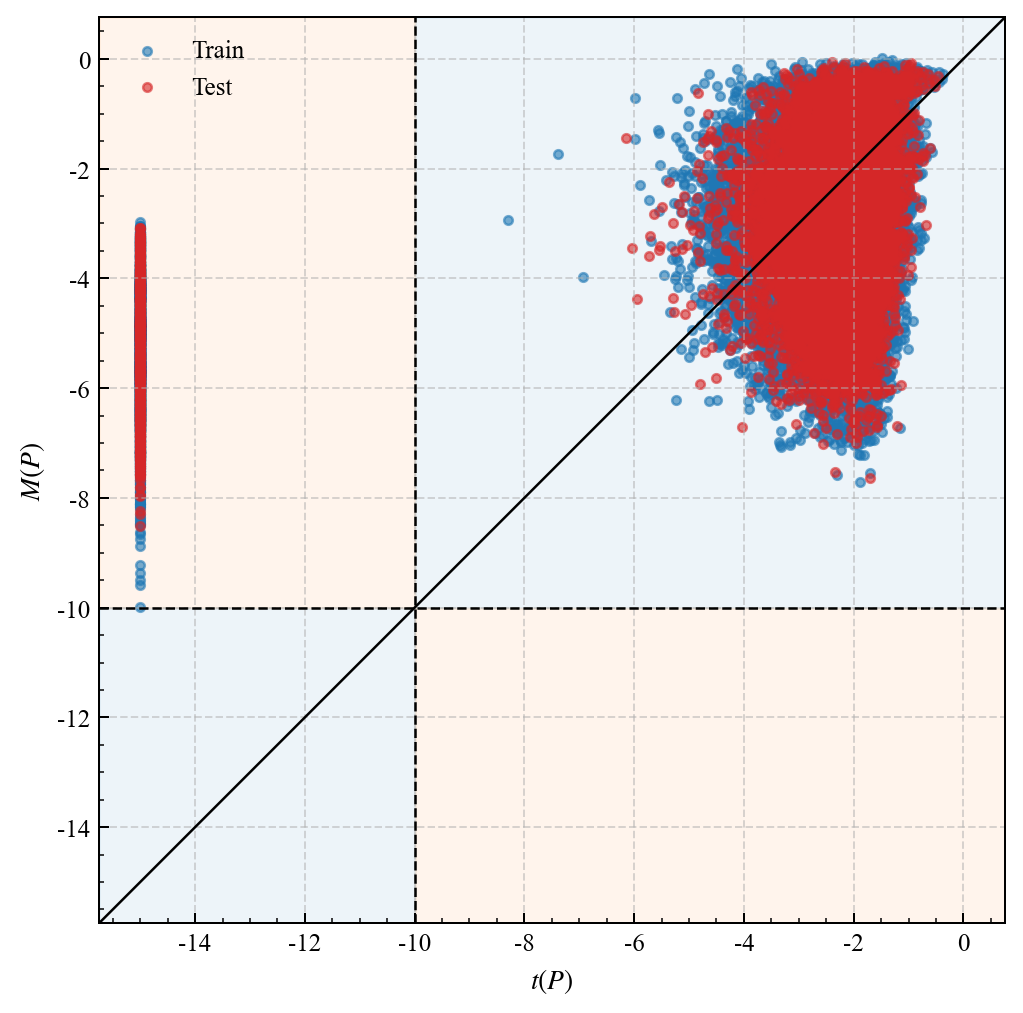

In [8]:
parity_plot_train_test(
    linear_model,
    train_loader,
    test_loader,
    device=device,
    c_trunc=1e-10,
)

### Train Quadratic Model

In [9]:
quadratic_model = LinearSurrogate(input_dim=3 * dataset.n_qubits).to(device)

### Train NN Model

### Train GNN Model